In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from tqdm import tqdm
import scipy
import time
import threading

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(123)
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from platform import python_version
print("Python version: ", python_version())
print("NetworkX version: ", nx.__version__)
print("Scipy version: ", scipy.__version__)
print("Numpy version: ", np.__version__)
print("GPy version: ", GPy.__version__)
print("TensorFlow version: ", tf.__version__)
print("TF Agents version: ", tf_agents.__version__)

Python version:  3.9.7
NetworkX version:  2.6.3
Scipy version:  1.7.1
Numpy version:  1.20.3
GPy version:  1.10.0
TensorFlow version:  2.8.0
TF Agents version:  0.11.0


In [2]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    b = kernel.K(X_v, X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])

In [3]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        sorted_nodes = sorted(sparse_nodes)
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]-1]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(X, Y, gp_model, graph, graph_dim, memory_window, gamma):
    for i in range(len(X)):
        l = variances[coord_to_id(X[i], graph_dim)]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y[i][0], memory_window, gamma)
    cumul_var = 0
    coeffs = 0
    for ele in variances:
        coeffs += ele[2]
        cumul_var += float(ele[0])*ele[2]
    variance = cumul_var/coeffs
    ###########################################
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    lengthscale, cpt = 0, 0
    for i in range(len(covariances)):
        if covariances[i][0]>1:
            covariance = covariances[i][1] - covariances[i][2]*covariances[i][3]
            if 0<covariance<variance:
                cpt += covariances[i][0]
                lengthscale += find_lengthscale(X_v[0], X_v[i+1], covariance, variance) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, variance, lengthscale

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

In [4]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = [60, 30, 20, 15, 10, 30, 27.5, 25, 17.5, 11.25, 20, 25, 22.5, 20, 12.5, 15, 17.5, 20, 17.5, 15, 10, 11.25, 12.5, 15, 12.5]
nb_agents = 6
exploration_steps = 25
variance_lengthscale = [10, 2]
memory_window = 1000
gamma = 0.997

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
covariances = [[0, 0, 0, 0] for _ in range(graph.number_of_nodes()-1)]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance_lengthscale[0], variance_lengthscale[1], memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))

gp_model = GPy.models.GPRegression(x, y, GPy.kern.RBF(2))
gp_model.optimize(messages=False)

moyenne, var, l = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
print("Variance: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

Variance:  7.102587673500872
Lengthscale:  [2.04531066]
Carte:  [59.73235482 32.29178614 19.96140899 14.6273486   9.62287523 32.11552907
 26.32580708 23.42204559 16.75472862  9.0532632  18.12702558 23.24095112
 24.13850122 19.03094347 12.9759214  12.87103999 16.8960803  18.73692827
 17.90248296 14.38394321  9.96150552  9.2792381  11.34516906 14.47060808
 12.80547446]
Incertitude initiale :  76.51867934794961


In [5]:
def update_gp_model(gp_model, x, y, graph, graph_dim, memory_window, gamma, display_gp_model=False):
    moy, variance, lengthscale = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
    X = np.concatenate((gp_model.X, x))[-1000:]
    Y = np.concatenate((gp_model.Y, y))[-1000:]
    gp_model.set_XY(X, Y)
    gp_model.optimize(messages=False)
    if display_gp_model:
        display(gp_model)
    return gp_model, moy, variance, lengthscale

def take_measurements(nodes, means, X_v, memory_window, gamma):
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance_lengthscale[0], lengthscale=variance_lengthscale[1])
    cov = simulation_kernel.K(X_v)
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    sorted_nodes = sorted(nodes)
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]-1]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    return X_v[nodes], Y_v[nodes]

In [6]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales = [variance_0], [lengthscale_0]
        self.train_env = train_env
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        if self.train_env:
            positions, mesures = take_measurements(actions, means, self.X_v, self.memory_window, self.gamma)
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%100
            if self.cpt_update_gp_model==0:
                self.gp_model, m, var, l = update_gp_model(self.gp_model, self.x, self.y, self.graph, self.graph_dim, self.memory_window, self.gamma)
                self.liste_variances.append(var)
                self.liste_lengthscales.append(l)
                self.moy = m
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [7]:
num_iterations = 10000
fc_layer_params = (128,64,)
replay_buffer_capacity = 300000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3
gamma = 0.99

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [8]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=False), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='MultiThreading_Politique_'+str(i), policy=eval_policies[-1]))

In [9]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)
            
class Train_Thread(threading.Thread):
    def __init__(self, event, iterator, agent):
        threading.Thread.__init__(self)
        self.event = event
        self.iterator = iterator
        self.agent = agent

    def run(self):
        experience, _ = next(self.iterator)
        self.agent.train(experience=experience)
        self.event.set()

In [11]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)

    iterators.append(iter(dataset))

In [12]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

start = time.time()
for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(1000)):
    collect_step(train_env, train_py_env, collect_policies)
events = [threading.Event() for _ in range(nb_agents)]
temps_execution = time.time() - start

for step in tqdm(range(1, num_iterations+1)):
    start = time.time()
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
        
    for event in events:
        event.clear()
    
    for i in range(nb_agents):
        thread = Train_Thread(events[i], iterators[i], agents_tf[i])
        thread.start()
        
    for event in events:
        event.wait()

    temps_execution += (time.time() - start) 
    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])

print("Execution Time: ", temps_execution)

18.762167


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


 10%|███████▌                                                                   | 1003/10000 [01:31<1:59:38,  1.25it/s]

step = 1000: Average Return = 27.405838012695312
Variance :  10.709488351109
Lengthscale :  [2.13064145]
MSE de la moyenne :  0.7996988361689027


 20%|███████████████                                                            | 2001/10000 [03:09<2:33:29,  1.15s/it]

step = 2000: Average Return = 35.26365280151367
Variance :  9.788293102841115
Lengthscale :  [2.05474622]
MSE de la moyenne :  0.44548544647457533


 30%|██████████████████████▌                                                    | 3001/10000 [04:51<2:17:10,  1.18s/it]

step = 3000: Average Return = 46.91075897216797
Variance :  10.197598536956077
Lengthscale :  [2.13042033]
MSE de la moyenne :  0.2811363441050984


 40%|██████████████████████████████                                             | 4001/10000 [06:33<2:01:02,  1.21s/it]

step = 4000: Average Return = 46.668975830078125
Variance :  9.899997953261488
Lengthscale :  [2.14452807]
MSE de la moyenne :  0.9059393524120243


 50%|█████████████████████████████████████▌                                     | 5001/10000 [08:19<1:37:10,  1.17s/it]

step = 5000: Average Return = 38.733375549316406
Variance :  9.83167328093306
Lengthscale :  [2.03568202]
MSE de la moyenne :  0.6063467288321671


 60%|█████████████████████████████████████████████                              | 6001/10000 [10:05<1:18:06,  1.17s/it]

step = 6000: Average Return = 39.37042999267578
Variance :  9.946631064524793
Lengthscale :  [1.97589207]
MSE de la moyenne :  0.2660092742205869


 70%|█████████████████████████████████████████████████████▉                       | 7001/10000 [11:46<58:38,  1.17s/it]

step = 7000: Average Return = 38.1429557800293
Variance :  10.236356903893352
Lengthscale :  [1.92354838]
MSE de la moyenne :  0.2843289733572205


 80%|█████████████████████████████████████████████████████████████▌               | 8001/10000 [13:31<40:26,  1.21s/it]

step = 8000: Average Return = 39.71796417236328
Variance :  9.815240706676525
Lengthscale :  [2.0663591]
MSE de la moyenne :  0.47892675054518


 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [15:17<20:00,  1.20s/it]

step = 9000: Average Return = 41.045265197753906
Variance :  9.653586735831826
Lengthscale :  [1.99013854]
MSE de la moyenne :  0.40536941577409813


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:57<00:00,  9.82it/s]

step = 10000: Average Return = 40.41889190673828
Variance :  9.737297430566214
Lengthscale :  [1.96336217]
MSE de la moyenne :  0.31579430700928823
Execution Time:  997.2269973754883


In [12]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

start = time.time()
for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(1000)):
    collect_step(train_env, train_py_env, collect_policies)
temps_execution = time.time() - start
    
for step in tqdm(range(1, num_iterations+1)):
    start = time.time()
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)

    temps_execution += (time.time() - start)
    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])
        
print("Execution Time: ", temps_execution)

19.535397


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


 10%|███████▌                                                                   | 1001/10000 [01:42<2:49:44,  1.13s/it]

step = 1000: Average Return = 21.8000431060791
Variance :  10.360777049932826
Lengthscale :  [2.05962428]
MSE de la moyenne :  1.335281401950001


 20%|███████████████                                                            | 2001/10000 [03:26<2:33:17,  1.15s/it]

step = 2000: Average Return = 40.176883697509766
Variance :  9.728559226716584
Lengthscale :  [2.07506677]
MSE de la moyenne :  0.48373607567050414


 30%|██████████████████████▌                                                    | 3001/10000 [05:12<2:14:29,  1.15s/it]

step = 3000: Average Return = 35.13014221191406
Variance :  10.927696366573407
Lengthscale :  [1.93341052]
MSE de la moyenne :  0.44451932935344485


 40%|██████████████████████████████                                             | 4001/10000 [06:58<2:00:54,  1.21s/it]

step = 4000: Average Return = 31.54530906677246
Variance :  10.044776718863544
Lengthscale :  [2.03814116]
MSE de la moyenne :  4.393701188410671


 50%|█████████████████████████████████████▌                                     | 5001/10000 [08:47<1:38:23,  1.18s/it]

step = 5000: Average Return = 16.10317611694336
Variance :  9.651532912399707
Lengthscale :  [2.0841846]
MSE de la moyenne :  2.7707924199176768


 60%|█████████████████████████████████████████████                              | 6001/10000 [10:42<1:17:41,  1.17s/it]

step = 6000: Average Return = 36.98417282104492
Variance :  9.975744203690786
Lengthscale :  [2.02071068]
MSE de la moyenne :  0.5252541875640513


 70%|█████████████████████████████████████████████████████▉                       | 7001/10000 [12:25<58:06,  1.16s/it]

step = 7000: Average Return = 38.68305969238281
Variance :  10.283714901748741
Lengthscale :  [1.99464646]
MSE de la moyenne :  0.8782754076137571


 80%|█████████████████████████████████████████████████████████████▌               | 8001/10000 [14:13<38:39,  1.16s/it]

step = 8000: Average Return = 39.34773254394531
Variance :  10.084532653586434
Lengthscale :  [2.0117988]
MSE de la moyenne :  0.3483434469007864


 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [15:56<19:27,  1.17s/it]

step = 9000: Average Return = 41.09564208984375
Variance :  9.77131728778496
Lengthscale :  [2.08288804]
MSE de la moyenne :  0.41053688029204055


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [17:39<00:00,  9.44it/s]

step = 10000: Average Return = 43.57168197631836
Variance :  9.777957419739145
Lengthscale :  [2.05876437]
MSE de la moyenne :  0.5208593993757098
Execution Time:  1045.1437935829163


## Résultats

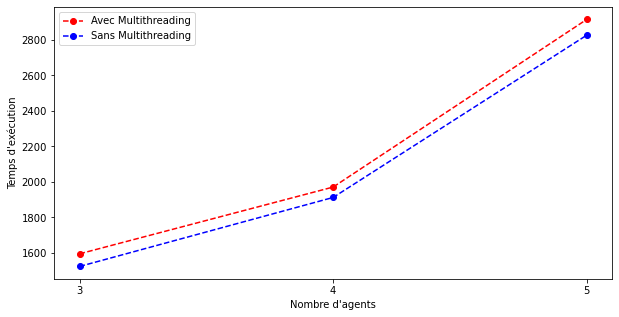

In [39]:
nb_agents = [3, 4, 5]
serv_res_opt = [1594.464802265167, 1970.9329478740692, 2916.3075466156006]
serv_res_nopt = [1523.2471199035645, 1912.3376867771149, 2827.3631596565247]

ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(nb_agents, serv_res_opt, "--or")
plt.plot(nb_agents, serv_res_nopt, "--ob")
plt.legend(["Avec Multithreading", "Sans Multithreading"], loc ="upper left")
plt.ylabel("Temps d'exécution")
plt.xlabel("Nombre d'agents")
plt.show()

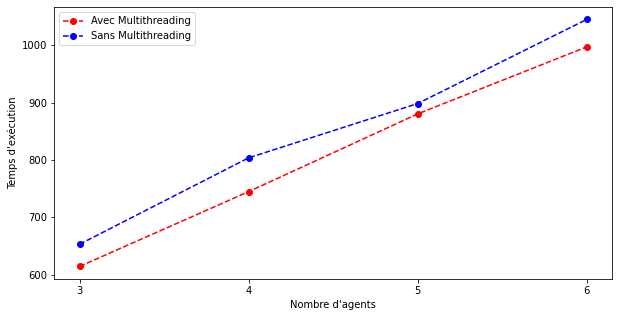

In [14]:
nb_agents = [3, 4, 5, 6]
pc_res_opt = [614.235107421875, 744.7073295116425, 880.3115310668945, 997.2269973754883]
pc_res_nopt = [652.9437737464905, 803.6504008769989, 898.3685305118561, 1045.1437935829163]

ax = plt.figure(figsize=(10,5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(nb_agents, pc_res_opt, "--or")
plt.plot(nb_agents, pc_res_nopt, "--ob")
plt.legend(["Avec Multithreading", "Sans Multithreading"], loc ="upper left")
plt.ylabel("Temps d'exécution")
plt.xlabel("Nombre d'agents")
plt.show()

In [ ]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)